In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T, Poisson_Model, LongTerm_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float)  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

#data = data[data.BoroName == 'Manhattan']



5.59615953107


In [11]:
((769 / 100000) * 8500000) / 52

1257.0192307692307

In [20]:
city_data = data.groupby('DATETIME')[['COUNT']].sum()
city_data['DATE_IND'] = range(0,city_data.shape[0]) 
city_data['DATE_IND'] += 1

city_data.DATE_IND = city_data.DATE_IND.astype(float) / 100
#city_data.DATE_IND = (city_data.DATE_IND - city_data.DATE_IND.mean()) / city_data.DATE_IND.std()

city_data = city_data.iloc[2:] # drop first week
city_data.reset_index(inplace = True)
city_data.head()

,DATETIME,COUNT,DATE_IND
0,2012-07-15,3320.0,0.03
1,2012-07-22,3376.0,0.04
2,2012-07-29,3232.0,0.05
3,2012-08-05,3168.0,0.06
4,2012-08-12,3356.0,0.07


In [21]:
search_periods = [[156,52]]
                 

In [22]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(city_data, start_date= '2012/07/15', training_end_date= s[0], \
                                                           testing_end_date=s[1], time_only = True)


    m = LongTerm_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= 1257.0 , period = 52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 5000)
    
    u.pred_GP(m,data_dict)
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


Beginning run [156, 52] : 
Training ends on: 2015-07-12 00:00:00
testing ends on: 2016-07-10 00:00:00
Initial neg. log-likelihood: -840914.498761
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 3275.917512
  Number of iterations: 5001
  Number of functions evaluations: 5376
added gp pred and error to test


KeyError: 'GRID_SQUARE'

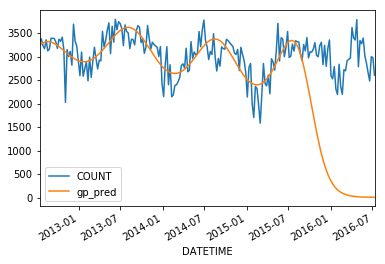

In [23]:
pred_train = m.predict_y(data_dict['X_train'])
train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
test[['gp_pred','COUNT']].plot

train.append(test)[['COUNT','gp_pred']].plot()


## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [116]:
output

,pred,seed
DATETIME,,
2014-07-13,522.403,[[-0.38902993933]]
2014-07-20,NaN,NaN
2014-07-27,NaN,NaN
2014-08-03,NaN,NaN
2014-08-10,NaN,NaN
2014-08-17,NaN,NaN
2014-08-24,NaN,NaN
2014-08-31,NaN,NaN
2014-09-07,NaN,NaN


In [132]:
[data_dict['X_train'][-1]]



[array([ 0.80890999])]

In [151]:

#m.predict_f()[0]
#[output.ix[0,'seed'][0]]
[data_dict['X_train'][-1]]

output

,pred,seed
DATETIME,,
2014-07-13,"([[522.402527839]], [[5300.47907437]])",[[-0.38902993933]]
2014-07-20,"([[522.402527839]], [[5300.47907437]])",NaN
2014-07-27,NaN,NaN
2014-08-03,NaN,NaN
2014-08-10,NaN,NaN
2014-08-17,NaN,NaN
2014-08-24,NaN,NaN
2014-08-31,NaN,NaN
2014-09-07,NaN,NaN


In [150]:

output = pd.DataFrame(index=test.index, columns=['pred','seed'])

output.ix[0,'seed'] = m.predict_f([data_dict['X_train'][-1]])[0]

for i in range(output.shape[0]):
    output.ix[i+1,'pred'] = m.predict_y([output.ix[0,'seed'][0]])


                                       
    if i > 0:
        m.predict_f([output.ix[i,'seed']])[0]

output


[nan]


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


ValueError: Cannot feed value of shape (1,) for Tensor 'autoflow/VGP/predict_f/Placeholder:0', which has shape '(?, ?)'

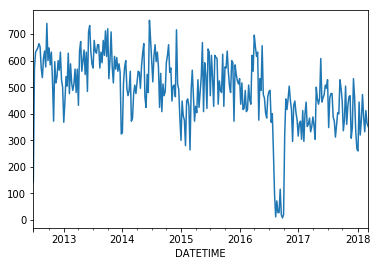

In [14]:
## Missing data 2016

data.groupby('DATETIME')['COUNT'].sum().plot()

In [ ]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

In [ ]:
test[test.GRID_SQUARE == 108][['gp_pred','COUNT']].plot()